# retrieve datasets

In [40]:
%%bash
cd ../data/external
mkdir -p fsdkaggle2018
cd fsdkaggle2018
if [ ! -d FSDKaggle2018.audio_test ]; then
    wget https://zenodo.org/records/2552860/files/FSDKaggle2018.audio_test.zip
    unzip FSDKaggle2018.audio_test.zip
    rm FSDKaggle2018.audio_test.zip
fi

if [ ! -d FSDKaggle2018.audio_train ]; then
    wget https://zenodo.org/records/2552860/files/FSDKaggle2018.audio_train.zip
    unzip FSDKaggle2018.audio_train.zip
    rm FSDKaggle2018.audio_train.zip
fi

if [ ! -d FSDKaggle2018.meta ]; then
    wget https://zenodo.org/records/2552860/files/FSDKaggle2018.meta.zip
    unzip FSDKaggle2018.meta.zip
    rm FSDKaggle2018.meta.zip
fi

ls

FSDKaggle2018.audio_test
FSDKaggle2018.audio_train
FSDKaggle2018.meta


# Setup and imports

In [41]:
import torch
import fastai.torch_core

import librosa

In [42]:
if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [43]:
device = None
if torch.cuda.is_available():
    device = fastai.torch_core.default_device('cuda')
elif torch.backends.mps.is_available():
    device = fastai.torch_core.default_device('mps')
else:
    device = fastai.torch_core.default_device('cpu')
    
device

device(type='cuda', index=0)

In [44]:
import pandas as pd

meta = pd.read_csv('../data/external/fsdkaggle2018/FSDKaggle2018.meta/train_post_competition.csv')

In [45]:
# Check out the first few rows of the dataframe
meta.head()

fname         label  manually_verified  freesound_id  \
0  00044347.wav        Hi-hat                  0         28739   
1  001ca53d.wav     Saxophone                  1        358827   
2  002d256b.wav       Trumpet                  0         10897   
3  0033e230.wav  Glockenspiel                  1        325017   
4  00353774.wav         Cello                  1        195688   

              license  
0         Attribution  
1         Attribution  
2  Creative Commons 0  
3         Attribution  
4         Attribution

In [46]:
# Add a column for the path to the audio file
meta['path'] = meta['fname'].apply(lambda x: f'../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/{x}')

In [47]:
meta.head()

fname         label  manually_verified  freesound_id  \
0  00044347.wav        Hi-hat                  0         28739   
1  001ca53d.wav     Saxophone                  1        358827   
2  002d256b.wav       Trumpet                  0         10897   
3  0033e230.wav  Glockenspiel                  1        325017   
4  00353774.wav         Cello                  1        195688   

              license  \
0         Attribution   
1         Attribution   
2  Creative Commons 0   
3         Attribution   
4         Attribution   

                                                                    path  
0  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav  
1  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav  
2  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav  
3  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav  
4  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav

Seems good.

In [48]:
# print labels
meta['label'].unique()

array(['Hi-hat', 'Saxophone', 'Trumpet', 'Glockenspiel', 'Cello', 'Knock',
       'Gunshot_or_gunfire', 'Clarinet', 'Computer_keyboard',
       'Keys_jangling', 'Snare_drum', 'Writing', 'Laughter', 'Tearing',
       'Fart', 'Oboe', 'Flute', 'Cough', 'Telephone', 'Bark', 'Chime',
       'Bass_drum', 'Bus', 'Squeak', 'Scissors', 'Harmonica', 'Gong',
       'Microwave_oven', 'Burping_or_eructation', 'Double_bass',
       'Shatter', 'Fireworks', 'Tambourine', 'Cowbell', 'Electric_piano',
       'Meow', 'Drawer_open_or_close', 'Applause', 'Acoustic_guitar',
       'Violin_or_fiddle', 'Finger_snapping'], dtype=object)

In [49]:
import IPython.display as ipd

# Check out the first row wav file using ipd
ipd.Audio(meta['path'][1])

In [50]:
print('Which is a ' + meta['label'][1])

Which is a Saxophone


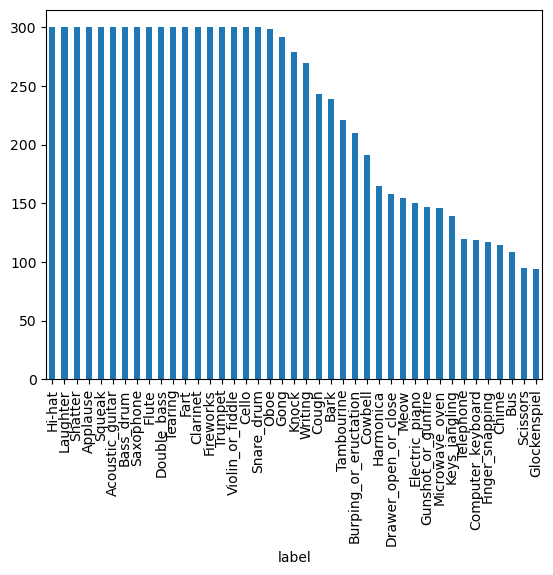

In [51]:
# Plot distribution of labels
import matplotlib.pyplot as plt

meta['label'].value_counts().plot(kind='bar')
plt.show()

# Find rms to check for low values

In [52]:
def check_max_rms(path):
    y, sr = librosa.load(path)
    rms = librosa.feature.rms(y=y)
    max_rms = max(rms[0])
    return max_rms

In [53]:
meta['rms'] = meta['path'].apply(check_max_rms)

In [54]:
meta.head()

fname         label  manually_verified  freesound_id  \
0  00044347.wav        Hi-hat                  0         28739   
1  001ca53d.wav     Saxophone                  1        358827   
2  002d256b.wav       Trumpet                  0         10897   
3  0033e230.wav  Glockenspiel                  1        325017   
4  00353774.wav         Cello                  1        195688   

              license  \
0         Attribution   
1         Attribution   
2  Creative Commons 0   
3         Attribution   
4         Attribution   

                                                                    path  \
0  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav   
1  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav   
2  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav   
3  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav   
4  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav   

        rms  
0  0.210343  
1  0.158867  
2  0.004181  
3  0.045153  
4  0.160564

In [55]:
ipd.Audio(meta['path'][2])

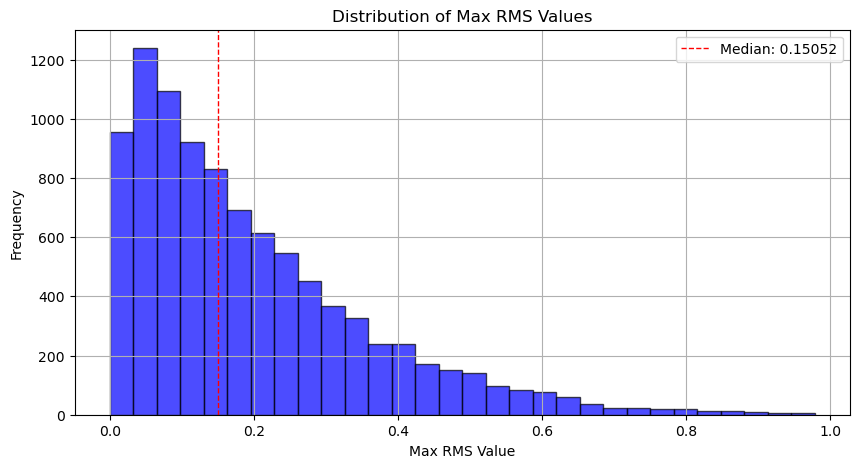

In [56]:
def plot_rms_distribution(df, rms_column='rms'):
    plt.figure(figsize=(10, 5))
    plt.hist(df[rms_column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    
    # Add a vertical line for the median
    median_value = df[rms_column].median()
    plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.5f}')
    
    # Add labels and title
    plt.title('Distribution of Max RMS Values')
    plt.xlabel('Max RMS Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Now call the function and pass the DataFrame
plot_rms_distribution(meta)

In [57]:
lower_rms_threshold = meta['rms'].quantile(0.001)
lower_rms_threshold

0.0007037947913631797

In [58]:
# Count the number of rows with RMS below the threshold
quiet_files = meta[meta['rms'] < lower_rms_threshold]
quiet_files_count = quiet_files.shape[0]

print(f"Number of quiet audio files: {quiet_files_count}")


Number of quiet audio files: 10


In [59]:
quiet_files.head()

fname    label  manually_verified  freesound_id  \
1705  2f1bb802.wav  Writing                  0        335019   
2266  3de081b1.wav    Knock                  0        113137   
2918  4eb54300.wav     Gong                  0         90874   
3430  5c92ea4b.wav  Tearing                  0        125332   
4600  7c82518c.wav  Writing                  0        219366   

                 license  \
1705         Attribution   
2266  Creative Commons 0   
2918         Attribution   
3430  Creative Commons 0   
4600  Creative Commons 0   

                                                                       path  \
1705  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/2f1bb802.wav   
2266  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3de081b1.wav   
2918  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav   
3430  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5c92ea4b.wav   
4600  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7c82518c.wav   

           rms  
1705  0.000544  
2266  0.000699  
2918  0.000067  
3430  0.000040  
4600  0.000339

In [60]:
ipd.Audio(quiet_files['path'].iloc[5])

In [61]:
# check how many of these are labeled as writing
quiet_files['label'].value_counts()

label
Writing       3
Gong          2
Knock         1
Tearing       1
Tambourine    1
Bark          1
Cough         1
Name: count, dtype: int64

This method didn't work that well.

# Spectrograms

In [62]:
# Check out the first row as spectrogram

import librosa

# Load the first audio file
y, sr = librosa.load(meta['path'][1], sr=None, mono=False)

mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=22000)

In [63]:
mel_spec.shape

(128, 889)

In [64]:
import numpy as np

log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

label = meta['label'][1]

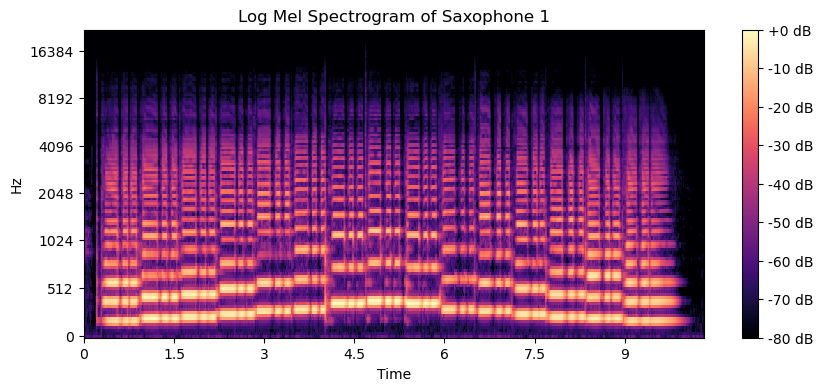

In [65]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Log Mel Spectrogram of {label} 1')
plt.show()

In [66]:
ipd.Audio(meta['path'][1])

In [67]:
# Compare the spectrograms of the two first entries with label saxophone
saxophones = meta[meta['label'] == 'Saxophone']

# Load the first audio file
y2, sr2 = librosa.load(saxophones['path'].iloc[1], sr=None, mono=False)

label2 = saxophones['label'].iloc[1]

mel_spec2 = librosa.feature.melspectrogram(y=y2, sr=sr2, n_mels=128, fmax=22000)

log_mel_spec2 = librosa.power_to_db(mel_spec2, ref=np.max)


Text(0.5, 1.0, 'Log Mel Spectrogram of Saxophone 2')

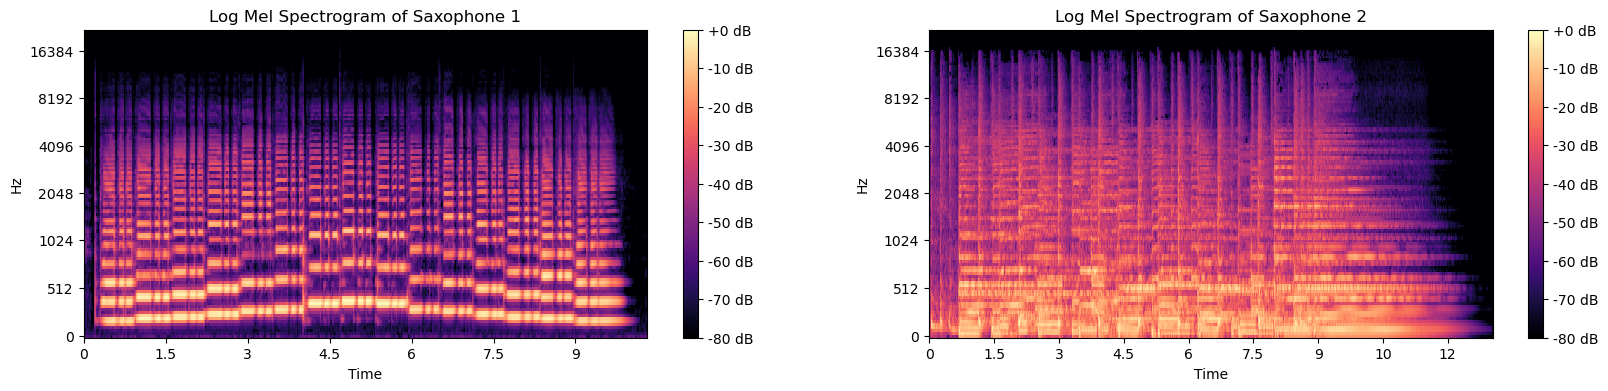

In [68]:
plt.figure(figsize=(20, 4))

plt.subplot(1,2,1)
librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Log Mel Spectrogram of {label} 1')

# plot second spectrogram
plt.subplot(1,2,2)
librosa.display.specshow(log_mel_spec2, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Log Mel Spectrogram of {label2} 2')

In [69]:
# compare wav
ipd.Audio(saxophones['path'].iloc[0])

In [70]:

ipd.Audio(saxophones['path'].iloc[1])

Seems like the second one, in addition to saxophone, has other instruments present. This could be useful when training the model on more diverse audio samples. It would also be nice to set multiple labels on it.

Additional labels:

- Bass drum
- Snare_drum
- Some kind of bass
- Some kind of organ/electric piano

Now let's convert all wav files into spectrograms

In [71]:
# iterate through all wav files and generate spectrograms

import os
import imageio
import matplotlib.cm as cm

def generate_spectrograms(meta, output_dir='../data/processed/fsdkaggle2018/spectrograms', fixed_length_seconds=3):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Sample rate
    sr = 44100  
    # Calculate fixed length in samples
    fixed_length_samples = int(fixed_length_seconds * sr)
    
    # Initialize an empty list to store spectrogram paths
    spectrogram_paths = []
    
    for index, row in meta.iterrows():
        # Load the audio file
        y, sr = librosa.load(row['path'], sr=sr, mono=True)
        
        if len(y) < fixed_length_samples:
            # Calculate the amount of silence needed
            padding_needed = fixed_length_samples - len(y)
            # Generate a random offset for the silence padding
            offset = np.random.randint(0, padding_needed)
            
            # Pad the audio signal with silence before and after based on the random offset
            silence_before = np.zeros(offset)
            silence_after = np.zeros(padding_needed - offset)
            y_padded = np.concatenate((silence_before, y, silence_after))
        else:
            # If the audio is longer than the fixed length, truncate it
            y_padded = y[:fixed_length_samples]
        
        # Generate the spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y_padded, sr=sr, n_mels=128, fmax=22000)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize the spectrogram
        norm_log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
        
        # Apply a colormap
        colored_spec = cm.viridis(norm_log_mel_spec)
        
        # Convert to RGB
        colored_spec_rgb = (colored_spec[..., :3] * 255).astype(np.uint8)

        # Define the file name and save path
        file_name = os.path.basename(row['path']).replace('.wav', '_spectrogram.png')
        save_path = os.path.join(output_dir, file_name)
        
        # Save the spectrogram image
        imageio.imwrite(save_path, colored_spec_rgb)
        
        # Append the save path to the list
        spectrogram_paths.append(save_path)
    
    # Add the list as a new column to the DataFrame
    meta['spectrogram_path'] = spectrogram_paths

    return meta  # Return the updated DataFrame
        

In [72]:
# Generate the spectrograms
directory = '../data/processed/fsdkaggle2018/spectrograms'

# Test the function using first 10 rows, but make a copy to avoid SettingWithCopyWarning
test_meta = meta.head(10).copy()

test = generate_spectrograms(test_meta, directory)

# Show first 10 rows
test.head(10)

fname               label  manually_verified  freesound_id  \
0  00044347.wav              Hi-hat                  0         28739   
1  001ca53d.wav           Saxophone                  1        358827   
2  002d256b.wav             Trumpet                  0         10897   
3  0033e230.wav        Glockenspiel                  1        325017   
4  00353774.wav               Cello                  1        195688   
5  003b91e8.wav               Cello                  0         77944   
6  003da8e5.wav               Knock                  1        164564   
7  0048fd00.wav  Gunshot_or_gunfire                  1        274119   
8  004ad66f.wav            Clarinet                  0        248370   
9  0063ab88.wav   Computer_keyboard                  0        210304   

              license  \
0         Attribution   
1         Attribution   
2  Creative Commons 0   
3         Attribution   
4         Attribution   
5         Attribution   
6  Creative Commons 0   
7  Creative Commons 0   
8         Attribution   
9  Creative Commons 0   

                                                                    path  \
0  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav   
1  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav   
2  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav   
3  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav   
4  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav   
5  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/003b91e8.wav   
6  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/003da8e5.wav   
7  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0048fd00.wav   
8  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/004ad66f.wav   
9  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0063ab88.wav   

        rms  \
0  0.210343   
1  0.158867   
2  0.004181   
3  0.045153   
4  0.160564   
5  0.073458   
6  0.094951   
7  0.553224   
8  0.132358   
9  0.032841   

                                                        spectrogram_path  
0  ../data/processed/fsdkaggle2018/spectrograms/00044347_spectrogram.png  
1  ../data/processed/fsdkaggle2018/spectrograms/001ca53d_spectrogram.png  
2  ../data/processed/fsdkaggle2018/spectrograms/002d256b_spectrogram.png  
3  ../data/processed/fsdkaggle2018/spectrograms/0033e230_spectrogram.png  
4  ../data/processed/fsdkaggle2018/spectrograms/00353774_spectrogram.png  
5  ../data/processed/fsdkaggle2018/spectrograms/003b91e8_spectrogram.png  
6  ../data/processed/fsdkaggle2018/spectrograms/003da8e5_spectrogram.png  
7  ../data/processed/fsdkaggle2018/spectrograms/0048fd00_spectrogram.png  
8  ../data/processed/fsdkaggle2018/spectrograms/004ad66f_spectrogram.png  
9  ../data/processed/fsdkaggle2018/spectrograms/0063ab88_spectrogram.png

In [73]:
# do all the rows
meta = generate_spectrograms(meta, directory)

 # Simple model
 Let's try to train a simple model on the raw data

In [74]:
from fastai.vision.all import *

# Create a DataBlock
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
               splitter=RandomSplitter(seed=42),
               get_x=ColReader('spectrogram_path'),
               get_y=ColReader('label'),
               item_tfms=Resize(224),
               batch_tfms=[RandomCrop(224), Normalize.from_stats(*imagenet_stats), RandomErasing(p=0.7)]
               )

In [75]:
dls = db.dataloaders(meta)

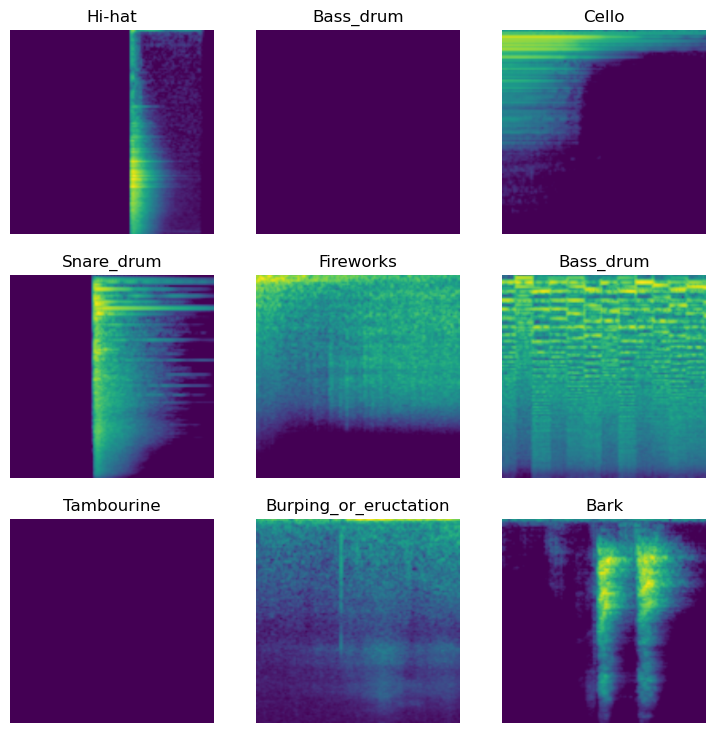

In [76]:
dls.show_batch()

In [77]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

SuggestedLRs(valley=0.001737800776027143)

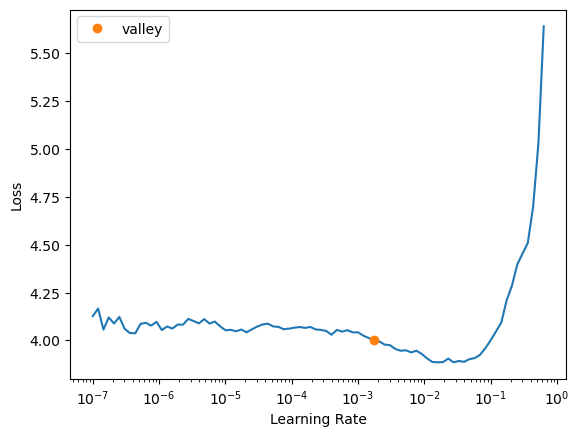

In [79]:
learn.lr_find()

In [81]:
learn.fine_tune(10, 0.001737800776027143)

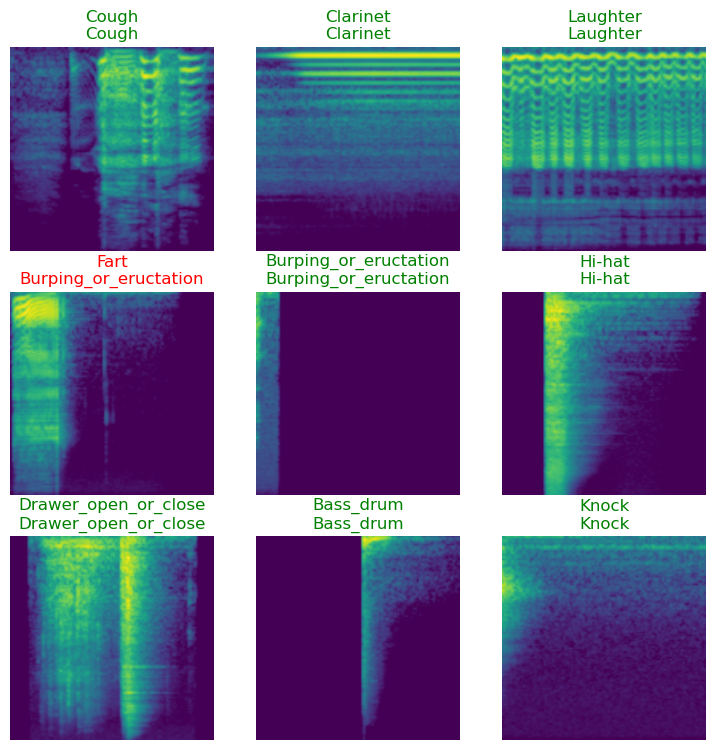

In [82]:
learn.show_results()

In [83]:
interp = ClassificationInterpretation.from_learner(learn)

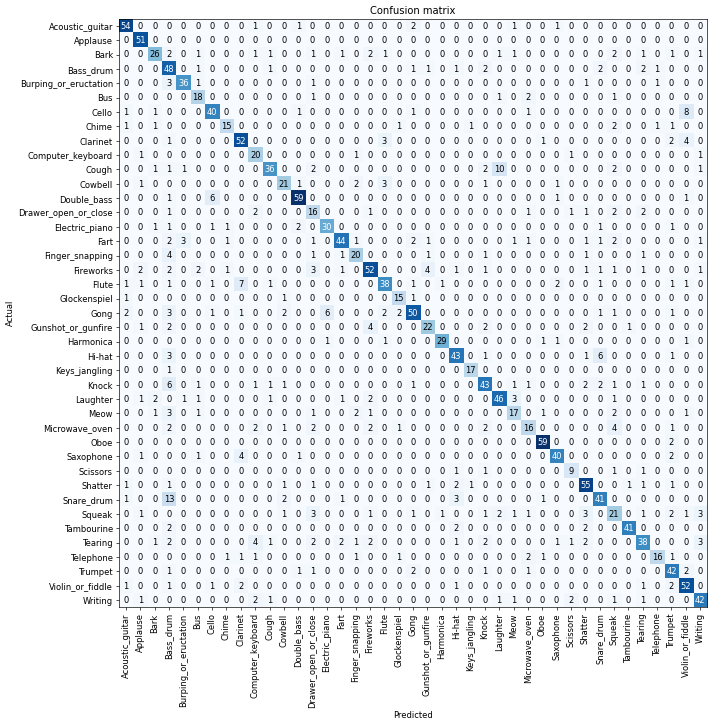

In [84]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [85]:
interp.most_confused()

[('Snare_drum', 'Bass_drum', 13),
 ('Cough', 'Laughter', 10),
 ('Cello', 'Violin_or_fiddle', 8),
 ('Flute', 'Clarinet', 7),
 ('Double_bass', 'Cello', 6),
 ('Gong', 'Electric_piano', 6),
 ('Hi-hat', 'Snare_drum', 6),
 ('Knock', 'Bass_drum', 6),
 ('Clarinet', 'Violin_or_fiddle', 4),
 ('Finger_snapping', 'Bass_drum', 4),
 ('Fireworks', 'Gunshot_or_gunfire', 4),
 ('Gunshot_or_gunfire', 'Fireworks', 4),
 ('Microwave_oven', 'Squeak', 4),
 ('Saxophone', 'Clarinet', 4),
 ('Tearing', 'Computer_keyboard', 4),
 ('Burping_or_eructation', 'Bass_drum', 3),
 ('Clarinet', 'Flute', 3),
 ('Cowbell', 'Flute', 3),
 ('Fart', 'Burping_or_eructation', 3),
 ('Fireworks', 'Drawer_open_or_close', 3),
 ('Gong', 'Bass_drum', 3),
 ('Hi-hat', 'Bass_drum', 3),
 ('Laughter', 'Meow', 3),
 ('Meow', 'Bass_drum', 3),
 ('Snare_drum', 'Hi-hat', 3),
 ('Squeak', 'Drawer_open_or_close', 3),
 ('Squeak', 'Shatter', 3),
 ('Squeak', 'Writing', 3),
 ('Tearing', 'Writing', 3),
 ('Acoustic_guitar', 'Gong', 2),
 ('Bark', 'Bass_drum',

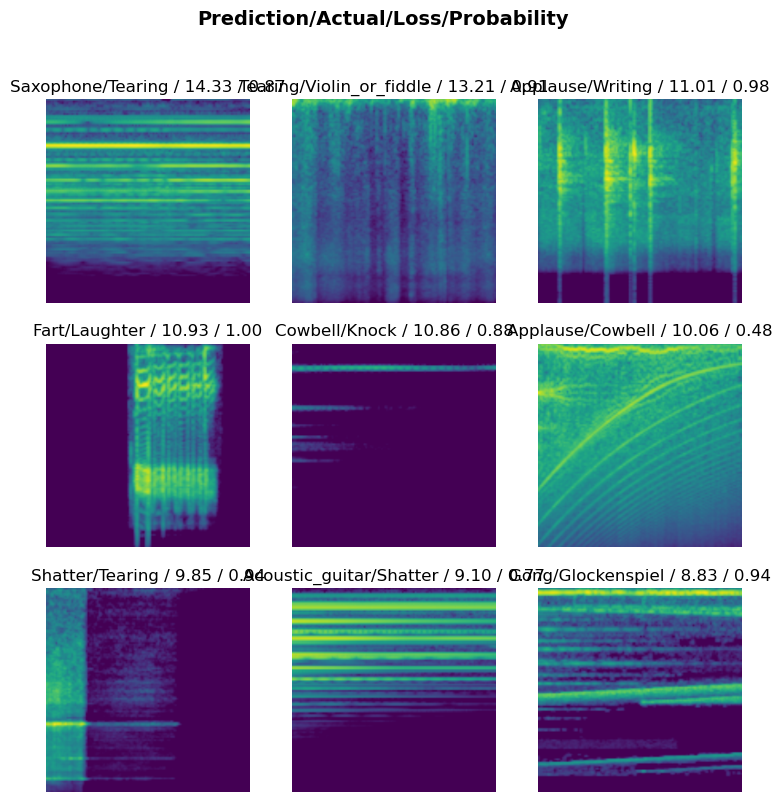

In [86]:
interp.plot_top_losses(9)

In [87]:
# save model
learn.export('../models/fsdkaggle2018_resnet34_basic.pkl')

Now let's test the model on our test set

In [88]:
# function for preparing data
def prepare_data(meta):
    
    meta['path'] = meta['fname'].apply(lambda x: f'../data/external/fsdkaggle2018/FSDKaggle2018.audio_test/{x}')
    
    spec_meta = generate_spectrograms(meta)
    
    return spec_meta

In [89]:
test_data = pd.read_csv('../data/external/fsdkaggle2018/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')

In [90]:
prepared_test_data = prepare_data(test_data)

In [91]:
test_dl = learn.dls.test_dl(prepared_test_data)

In [92]:
# Making predictions on the test set
preds, _ = learn.get_preds(dl=test_dl)

In [93]:
pred_classes = [learn.dls.vocab[i] for i in preds.argmax(dim=-1)]

In [94]:
pred_classes[:5]

['Oboe', 'Bass_drum', 'Clarinet', 'Saxophone', 'Chime']

In [95]:
prepared_test_data['predicted_label'] = pred_classes

In [96]:
prepared_test_data.head()

fname      label    usage  freesound_id             license  \
0  00326aa9.wav       Oboe  Private        355125         Attribution   
1  0038a046.wav  Bass_drum  Private         90621  Creative Commons 0   
2  007759c4.wav  Saxophone  Private         13406  Creative Commons 0   
3  008afd93.wav  Saxophone  Private        358962         Attribution   
4  00ae03f6.wav      Chime  Private         78203         Attribution   

                                                                   path  \
0  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_test/00326aa9.wav   
1  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_test/0038a046.wav   
2  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_test/007759c4.wav   
3  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_test/008afd93.wav   
4  ../data/external/fsdkaggle2018/FSDKaggle2018.audio_test/00ae03f6.wav   

                                                        spectrogram_path  \
0  ../data/processed/fsdkaggle2018/spectrograms/00326aa9_spectrogram.png   
1  ../data/processed/fsdkaggle2018/spectrograms/0038a046_spectrogram.png   
2  ../data/processed/fsdkaggle2018/spectrograms/007759c4_spectrogram.png   
3  ../data/processed/fsdkaggle2018/spectrograms/008afd93_spectrogram.png   
4  ../data/processed/fsdkaggle2018/spectrograms/00ae03f6_spectrogram.png   

  predicted_label  
0            Oboe  
1       Bass_drum  
2        Clarinet  
3       Saxophone  
4           Chime

In [97]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(prepared_test_data['label'], prepared_test_data['predicted_label'])
print(f"Accuracy: {accuracy}")


Accuracy: 0.7825
